# Imports

In [3]:
!pip install plotly
!pip install cufflinks

  Using cached Jinja2-2.11.3-py2.py3-none-any.whl (125 kB)
  Created wheel for cufflinks: filename=cufflinks-0.17.3-py3-none-any.whl size=68724 sha256=b5386ee15f84a8d903d26958ff7a3b92868a79c272f74aed756a40da0fd69008
  Stored in directory: c:\users\thpinto\appdata\local\pip\cache\wheels\6b\76\62\6da97734911ffcbdd559fd1a3f28526321f0ae699182a23866
  Created wheel for pyrsistent: filename=pyrsistent-0.17.3-cp38-cp38-win_amd64.whl size=55869 sha256=08008371eec508b6d2a5151f414202fcb706b3587ebcc55474564264681fe355
  Stored in directory: c:\users\thpinto\appdata\local\pip\cache\wheels\3d\22\08\7042eb6309c650c7b53615d5df5cc61f1ea9680e7edd3a08d2
  Created wheel for pandocfilters: filename=pandocfilters-1.4.3-py3-none-any.whl size=7992 sha256=9dae37287c887986a728bbffd261f89beee5f8decc591ac4d5f31651bffa1628
  Stored in directory: c:\users\thpinto\appdata\local\pip\cache\wheels\fc\39\52\8d6f3cec1cca4ceb44d658427c35711b19d89dbc4914af657f
Successfully built cufflinks pyrsistent pandocfilters


In [1]:
import pandas as pd
from sklearn import cluster as c
import seaborn as sns
from matplotlib import pyplot as plt

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from plotly import express as px

from sklearn import metrics as m
import umap.umap_ as umap 


from IPython.core.display import HTML
from IPython.display import Image

# Funções Auxiliares

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    sns.set(font_scale=1.6)
    plt.style.use('seaborn-darkgrid')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 16
    display( HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


# Data Load

In [3]:
data_raw = pd.read_csv('../Data/Ecommerce.csv')
data_raw = data_raw.drop(['Unnamed: 8'], axis=1)
data_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


# 1.0 - Descrição dos Dados

In [4]:
df1 = data_raw.copy()

## 1.1 - Rename Columns

In [5]:
new_cols = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date' ,'unit_price', 'customer_id', 'country']

df1.columns = new_cols

## 1.2 - Dimensão dos Dados

In [6]:
print( 'Numero de Linhas: {}'.format(df1.shape[0]) )
print( 'Numero de Colunas: {}'.format(df1.shape[1]) )

Numero de Linhas: 541909
Numero de Colunas: 8


## 1.3 - Tipo dos Dados

In [7]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 - Check NA

In [8]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 - Preencher NA

In [9]:
# Para esse primeiro ciclo.. preferi dropar os dados NA
df1 = df1.dropna(subset=['description', 'customer_id'])
print('Percentual dropado: {:.2f}%'. format( 1- (df1.shape[0] / data_raw.shape[0]) ) )

Percentual dropado: 0.25%


## 1.6 Alterar Tipo dos Dados

In [10]:
df1['customer_id'] = df1['customer_id'].astype( int )

df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')  

In [11]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom


## 1.7 Estatística Descritiva

# 2.0 Feature Engineering

In [52]:
df2 = df1.copy()

## 2.1 Feature Creation

In [53]:
#data reference
df_ref = df2.drop( ['invoice_no','stock_code', 
                    'description', 'quantity', 
                    'invoice_date', 'unit_price', 'country'], axis=1 ).drop_duplicates(ignore_index=True)

# Gross Revenue ( Faturamento ) = quantity * price

df2['gross_revenue'] = df2['quantity'] * df2['unit_price']

#Monetary
df_monetary = df2[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')



# Recency - Last Day purchase
df_recency = df2[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = ( df2['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id','recency_days']].copy()

df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')


# Frequency
df_freq = df2[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')


# Avg Ticket
df_avg_ticket = df2[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue': 'avg_ticket'})
df_ref = pd.merge(df_ref, df_avg_ticket, on='customer_id', how='left')
df_ref.head()


,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket
0,17850,5288.63,302,35,16.950737
1,13047,3079.10,31,18,15.709694
2,12583,7187.34,2,18,28.634821
3,13748,948.25,95,5,33.866071
4,15100,635.10,330,6,105.850000


# 3.0 Filtragem de Variáveis

In [54]:
df3 = df_ref.copy()

# 4.0 Exploratory Data Analysis

In [55]:
df4 = df3.copy()

# 5.0 Data Preparation

In [56]:
df5 = df4.copy()

# 6.0 Feature Selection

In [57]:
df6 = df5.copy()

# 7.0 Hyperparameter Fine-Tunning

In [58]:
X = df6.drop( columns=['customer_id'] )

In [59]:
clusters = [2,3,4,5,6,7]

## 7.1 Within Cluster Sum of Square (WSS)

[]

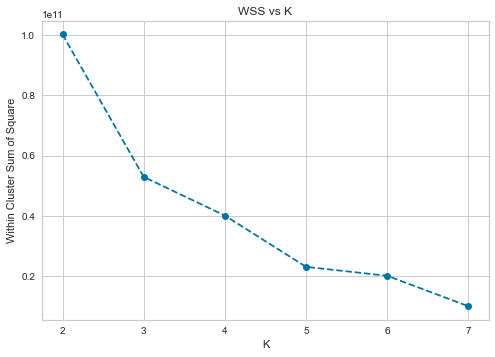

In [60]:
wss = []

for k in clusters:
    
    #model definition
    kmeans = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)
    
    #model trainning
    kmeans.fit( X ) 
    
    #model validation
    wss.append(kmeans.inertia_)

    
#plot wss - Elbow Method
    
plt.plot(clusters, wss, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Within Cluster Sum of Square');
plt.title('WSS vs K');
    
plt.plot()

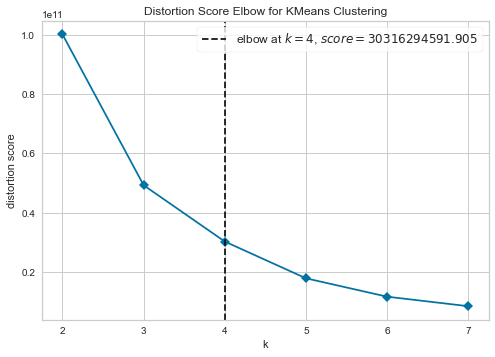

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [61]:


kmeans = KElbowVisualizer( c.KMeans(), k=clusters, timings=False )
kmeans.fit(X)
kmeans.show()

## 7.1 Sillhouette Score

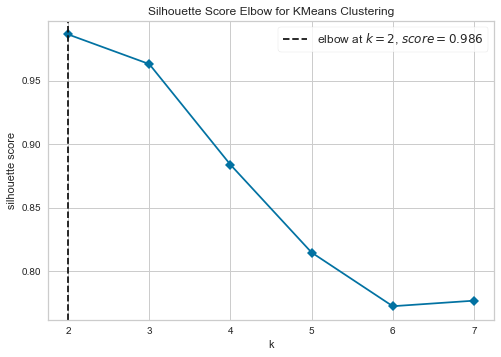

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [62]:
from yellowbrick.cluster import KElbowVisualizer

kmeans = KElbowVisualizer( c.KMeans(), k=clusters, metric='silhouette', timings=False )
kmeans.fit(X)
kmeans.show()

## 7.2 Silhouette Analysis 

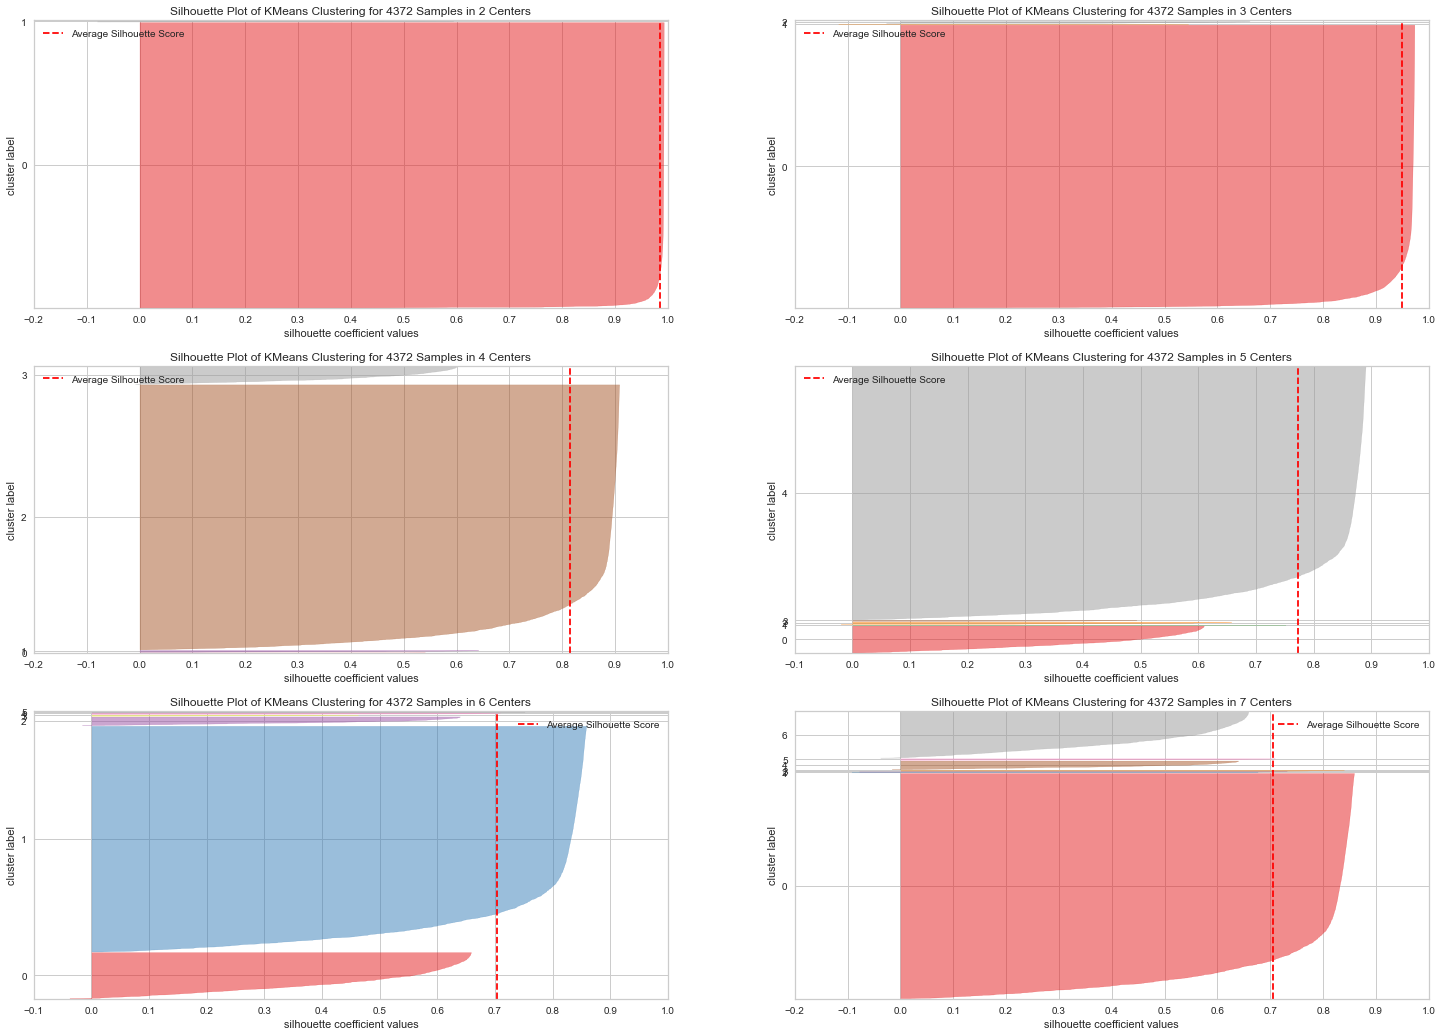

In [72]:
fig, ax = plt.subplots( 3, 2, figsize=(25,18) )

for k in clusters:
    km = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(k,2)
    visualizer = SilhouetteVisualizer( km, color = 'yellowbrick', ax= ax[q-1][mod] )
    visualizer.fit( X )
    visualizer.finalize()

# 8.0 Model Training

## 8.1 K-Means

In [78]:
# model definition
k = 4
kmeans = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

# model trainning
kmeans.fit( X ) 

# clustering
#labels = kmeans.predict( X )
labels = kmeans.labels_


## 8.2 Cluster Validation

In [79]:
## WSS
print('WSS values: {}'.format(kmeans.inertia_) )



## SS
print('SS value: {}'.format( m.silhouette_score( X, labels, metric='euclidean' ) ) )



WSS values: 40056254626.30002
SS value: 0.8139972028952442


# 9.0 Cluster Analysis

In [98]:
df9 = df6.copy()
df9['cluster'] = labels

## 9.1 Visualization Inspection

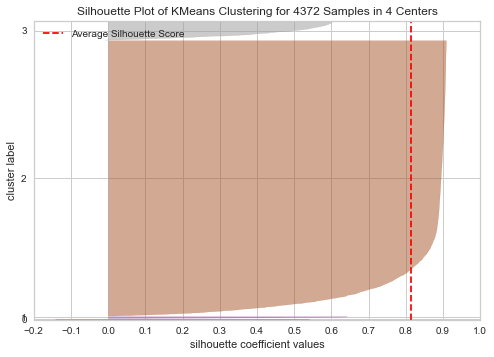

In [99]:
visualizer = SilhouetteVisualizer( kmeans, color = 'yellowbrick')
visualizer.fit( X )
visualizer.finalize()

## 9.2 2d plot

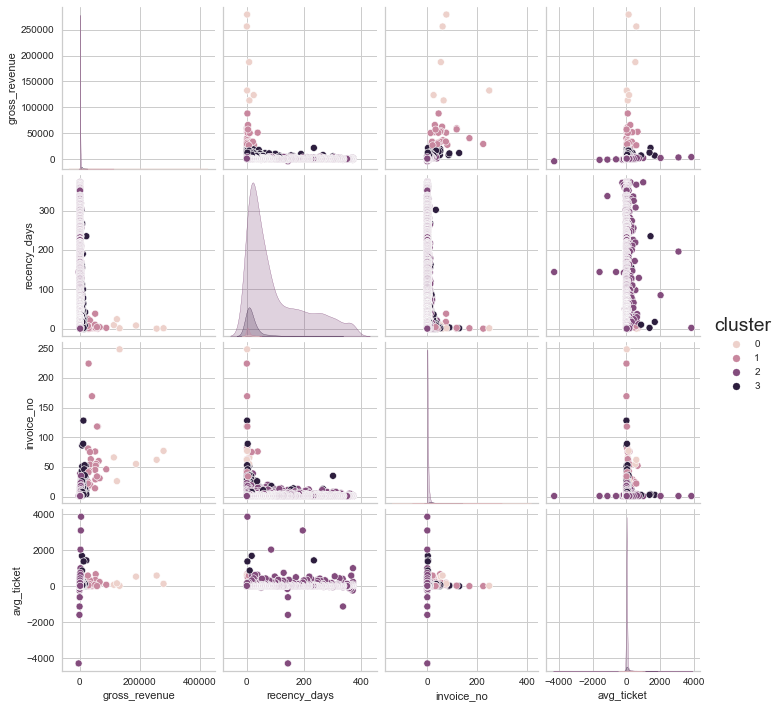

In [100]:
df_viz = df9.drop(columns='customer_id', axis=1)
sns.pairplot(df_viz, hue='cluster')

## 9.3 UMAP

In [101]:
df_viz.head()

,gross_revenue,recency_days,invoice_no,avg_ticket,cluster
0,5288.63,302,35,16.950737,3
1,3079.10,31,18,15.709694,2
2,7187.34,2,18,28.634821,3
3,948.25,95,5,33.866071,2
4,635.10,330,6,105.850000,2


<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

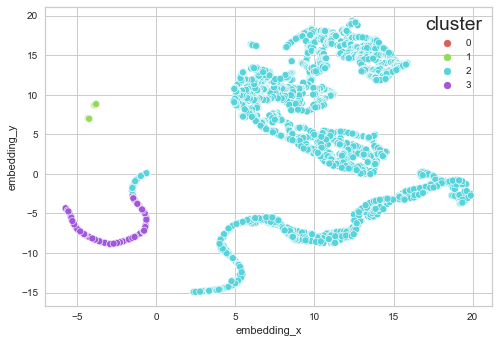

In [102]:
reducer = umap.UMAP( n_neighbors = 10, random_state = 42 )
embedding = reducer.fit_transform( X )

#embedding

df_viz['embedding_x'] = embedding[:,0]
df_viz['embedding_y'] = embedding[:,1]

#plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster', palette=sns.color_palette('hls', n_colors= len( df_viz['cluster'].unique() ) ),
                    data = df_viz
                )

In [103]:
#fig = px.scatter_3d( df9, x='recency_days', y='invoice_no', z='gross_revenue', color='cluster' )
#fig.show()

## 9.2 Cluster Profile

In [104]:
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,cluster
0,17850,5288.63,302,35,16.950737,3
1,13047,3079.10,31,18,15.709694,2
2,12583,7187.34,2,18,28.634821,3
3,13748,948.25,95,5,33.866071,2
4,15100,635.10,330,6,105.850000,2


In [106]:
# Number of customer
df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['percentual'] = df_cluster['customer_id'] / df_cluster['customer_id'].sum() * 100
#df_cluster

# Avg gross revenue
df_gross_revenue_cluster = df9[['gross_revenue','cluster']].groupby('cluster').mean().reset_index()
#df_gross_revenue_cluster['percentual'] = df_gross_revenue_cluster['gross_revenue'] / df_cluster['gross_revenue'].sum() * 100
df_cluster = pd.merge( df_cluster, df_gross_revenue_cluster, on='cluster', how='left' )
df_cluster


# Avg RECENCY
df_recency = df9[['recency_days','cluster']].groupby('cluster').mean().reset_index()
#df_gross_revenue_cluster['percentual'] = df_gross_revenue_cluster['gross_revenue'] / df_cluster['gross_revenue'].sum() * 100
df_cluster = pd.merge( df_cluster, df_recency, on='cluster', how='left' )
df_cluster


#Avg invoice
df_invoice = df9[['invoice_no','cluster']].groupby('cluster').mean().reset_index()
#df_gross_revenue_cluster['percentual'] = df_gross_revenue_cluster['gross_revenue'] / df_cluster['gross_revenue'].sum() * 100
df_cluster = pd.merge( df_cluster, df_invoice, on='cluster', how='left' )

#avg_ticket
df_avg_ticket = df9[['avg_ticket', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_ticket, on='cluster', how='left' )

df_cluster 

,cluster,customer_id,percentual,gross_revenue,recency_days,invoice_no,avg_ticket
0,0,6,0.137237,182181.981667,7.166667,89.000000,253.626345
1,1,28,0.640439,42614.387143,6.178571,57.821429,162.862605
2,2,4071,93.115279,946.696250,96.969295,3.641120,25.359654
3,3,267,6.107045,8089.028652,20.280899,19.528090,62.783157


,customer_id,avg_ticket
0,12346,0.000000
1,12347,23.681319
2,12348,57.975484
3,12349,24.076027
4,12350,19.670588


## Cluster 01 (Candidato à Insider)

    - Número de Customers: 6 (0.14% dos clientes)

    - Recência em Média: 7 dias
    
    - Compras em Média: 89 compras
    
    - Receita em Média: 182.181,00 dolares


## Cluster 02

     - Número de Customers: 31 (0.7% dos clientes)

     - Recência em Média: 13 dias
     
     - Compras em Média: 53 compras

     - Receita em Média: 40.543 dolares


## Cluster 03

     - Número de Customers: 4335 (99% dos clientes)

     - Recência em Média: 92 dias
     
     - Compras em Média: 4 compras
     
     - Receita em Média: 1.372 dolares


# 9.0 Deploy to Production

# ---------> ESTUDAR T-SNE

In [54]:
#model_definition
affinity = c.AffinityPropagation( damping=0.5, max_iter=200, convergence_iter=15, copy=True, preference=None, affinity='euclidean', verbose=False, random_state='warn'  )

# model trainning

affinity.fit( X ) 

# clustering
#labels = kmeans.predict( X )
labels = affinity.labels_



D:\programas\Anaconda3\lib\site-packages\sklearn\cluster\_affinity_propagation.py:148: FutureWarning:

'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.

D:\programas\Anaconda3\lib\site-packages\sklearn\cluster\_affinity_propagation.py:246: ConvergenceWarning:

Affinity propagation did not converge, this model will not have any cluster centers.



In [57]:
## WSS
#print('WSS values: {}'.format(affinity.predict( X )) )



## SS
print('SS value: {}'.format( m.silhouette_score( X, labels, metric='euclidean' ) ) )

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)